In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn
from glob import glob
from functools import  reduce
from itertools import combinations
from IPython.display import display
color_map = matplotlib.cm.rainbow(np.linspace(0, 1, 10))
seaborn.set_style("whitegrid")

In [2]:
def highlight(s, kind='min'):
    '''
    highlight the maximum or the minimum in a Series yellow.
    '''
    s = pd.to_numeric(s, errors='coerce')
    predicat = s == s.min() if kind=='min' else s.max()
    return ['color: red' if v else 'color: black' for v in predicat]

In [38]:
def summarize_results(expts_folder, show_figures=True, select_best_on_valid=False):
    res_folders = [el for el in os.listdir(expts_folder) 
               if os.path.isdir(os.path.join(expts_folder, el))]
    metric = "pcc_mean"
    dfs = []
    for res_folder in res_folders:
        print(res_folder)
        if select_best_on_valid:
            fnames = []
            template = os.path.join(expts_folder, res_folder) + '/log*'
            template_fnames = glob(template)
            groups = set([el.split('--')[0] for el in template_fnames])
            for group_template in groups:
                group_fnames = glob(group_template+'*')
                group_fnames = [el for el in group_fnames
                               if os.path.isfile(el.replace('log_', 'results_').replace('_kshot', '_shot'))]
                best_val_loss = float('Inf')
                best_hp =None
                for fname in group_fnames:
                    try:
                        temp = pd.read_csv(fname, delimiter='\t')
                    except pd.errors.EmptyDataError:
                        continue
                    val_loss = temp.val_loss.min()
                    if best_val_loss > val_loss:
                        best_val_loss = val_loss
                        best_hp = fname
                if best_hp:
                    the_resfile = best_hp.replace('log_', 'results_')
                    the_resfile = the_resfile.replace('_kshot', '_shot')
                    if os.path.isfile(the_resfile):
                        fnames += [the_resfile]        
        else:            
            template = os.path.join(expts_folder, res_folder) + '/results*'
            fnames = glob(template)
        res_all_hps = []
        temp = None
        for fname in fnames:
            try:
                temp = pd.read_csv(fname, delimiter='\t')
            except pd.errors.EmptyDataError:
                continue
            if temp.shape[1] < 2:
                temp = pd.read_csv(fname, delimiter='\t', skiprows=1)
                temp = temp.dropna(how='any', axis=0)
                temp = temp.drop_duplicates(keep=False)
                # temp = temp.loc[[temp.pcc_median.argmax()]] 
                temp = temp[pd.to_numeric(temp[metric], errors='coerce').notnull()]
                temp = temp.loc[temp.groupby(["name"])[metric].idxmax()] 
            res_all_hps.append(temp)
        
        if len(res_all_hps) > 0:
            # print(res_all_hps)
            algo_name = '_'.join(res_folder.split('_')[2:-1])
            res = pd.concat(res_all_hps, ignore_index=True)
            # print(res)
            # res['hps'] = ['_'.join(f.split('/')[-1].split('_')[5:]) for f in fnames]
            res[metric] = pd.to_numeric(res[metric])
            res['size'] = pd.to_numeric(res['size'])
            res = res.loc[res.groupby(["name"])[metric].idxmax()] 
            res.to_csv(os.path.join(expts_folder, 'recap_'+res_folder+'.txt'), 
                       index=False,  float_format='%.3f')
            if show_figures:
                print('%{} > 0'.format(metric), res[metric].gt(0).mean())
                print('%{} > 0.5'.format(metric), res[metric].gt(0.5).mean())
#                 res.plot.scatter('size', metric)
#                 plt.title(algo_name)
#                 plt.show()
            sizes = res['size'].as_matrix()
            cs = [color_map[np.log(x).astype('int')] for x in sizes]
            dfs.append(res[['name', metric]].set_index('name').rename(
                columns={metric: algo_name}))

    res = pd.concat(dfs, axis=1).apply(pd.to_numeric)
    # res = res.drop(['krr', 'krr_1surM_uniquel2'], axis=1)
    res = res.reindex_axis(sorted(res.columns, reverse=True), axis=1)
    if show_figures:
        res = res.rename(columns={'krr': 'MetaKRR'})
        res = res.rename(columns={'maml': 'MAML'})
        res = res.rename(columns={'mann': 'MANN'})
        for x, y in combinations(res.columns.tolist(), 2):
            print('% x > y', res[x].gt(res[y]).mean())
            plt.figure()
            fig, ax = plt.subplots()
            s = ax.scatter(res[x].as_matrix(), res[y].as_matrix(), c=sizes, s=5.,
                          norm=matplotlib.colors.LogNorm())
            ax.plot((-1, 1), (-1, 1), c='k', ls="-", )
            cbar = plt.colorbar(mappable=s, ax=ax)
            cbar.set_label('Dataset size')
            plt.xlim((-1, 1))
            plt.ylim((-1, 1))
            plt.xlabel(x)
            plt.ylabel(y)
            plt.xticks([-1, -0.5, 0, 0.5, 1])
            plt.yticks([-1, -0.5, 0, 0.5, 1])
            plt.show()
            plt.close()
    else:
        res.loc['Average'] = res.mean()
        highlight_max = lambda x: highlight(x, 'max')
        display(res)
        # print(res.to_latex(float_format='%.3f'))
#         display(res.style.apply(highlight_max, axis=1).set_precision(3))

results_mhc_maml_cnn
results_mhc_krr_cnn
results_mhc_mann_cnn
results_mhc_snail_cnn


,snail,mann,maml,krr
name,,,,
HLA-DRB1*0101,0.522745,0.452076,0.428737,0.470217
HLA-DRB1*0301,0.494555,0.416080,0.391284,0.532698
HLA-DRB1*0401,0.505293,0.429927,0.418595,0.547195
HLA-DRB1*0404,0.551182,0.492068,0.441113,0.563367
HLA-DRB1*0405,0.601094,0.527518,0.510776,0.628687
HLA-DRB1*0701,0.681696,0.606711,0.573918,0.705989
HLA-DRB1*0802,0.422317,0.427039,0.380714,0.424604
HLA-DRB1*0901,0.519872,0.461507,0.380914,0.533105
HLA-DRB1*1101,0.595267,0.542025,0.524757,0.627132


results_bindingdb_maml_cnn
results_bindingdb_snail_cnn
results_bindingdb_krr_cnn
%pcc_mean > 0 0.8983957219251337
%pcc_mean > 0.5 0.19786096256684493
results_bindingdb_mann_cnn
%pcc_mean > 0 0.7080213903743315
%pcc_mean > 0.5 0.12406417112299466
% x > y 0.3689839572192513


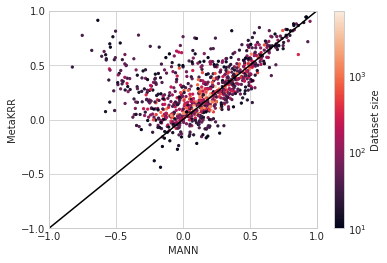

results_movielens_krr_fc
%pcc_mean > 0 1.0
%pcc_mean > 0.5 0.546
results_movielens_mann_fc
%pcc_mean > 0 0.99
%pcc_mean > 0.5 0.531
results_movielens_snail_fc
results_movielens_maml_fc
%pcc_mean > 0 0.991
%pcc_mean > 0.5 0.519
% x > y 0.661


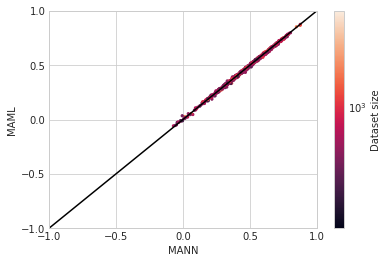

% x > y 0.342


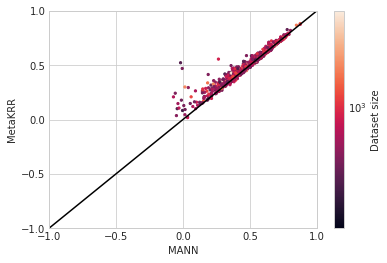

% x > y 0.264


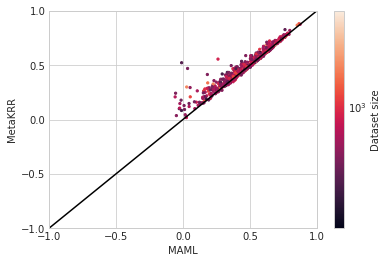

In [40]:

p= '../results/expts_2/'
summarize_results(p+'mhc', show_figures=False, select_best_on_valid=True)
summarize_results(p+'bindingdb', show_figures=True, select_best_on_valid=True)
summarize_results(p+'movielens', show_figures=True, select_best_on_valid=True)


In [25]:
def show_l2(fname):
    temp = pd.read_csv(fname, delimiter='\t')
    y = temp.l2
    plt.plot(y)
    plt.show()

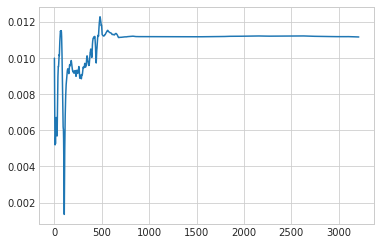

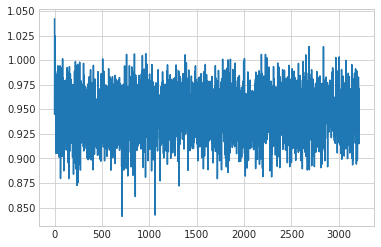

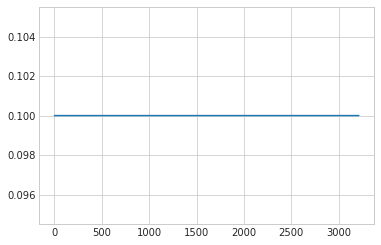

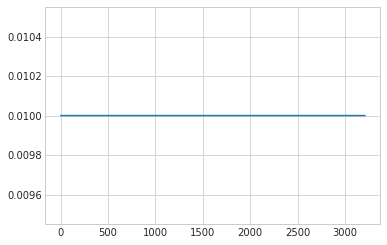

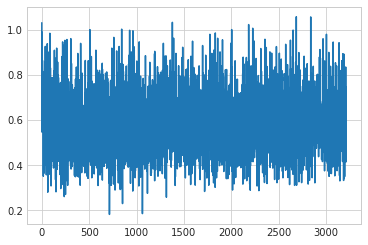

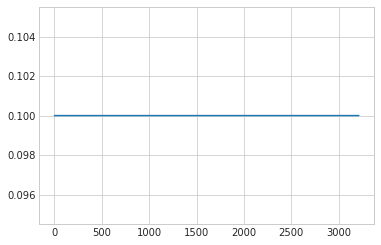

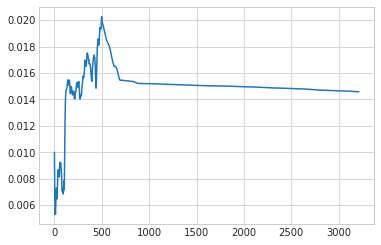

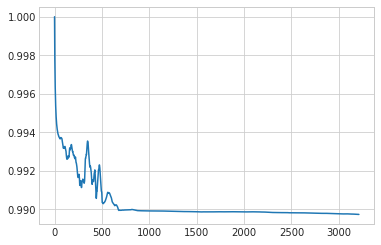

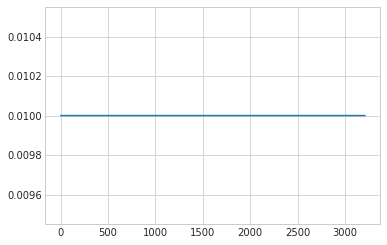

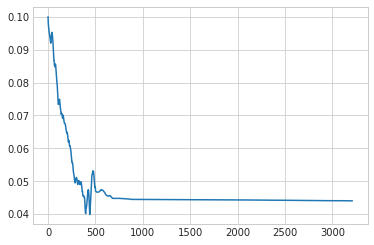

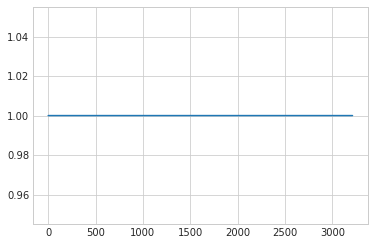

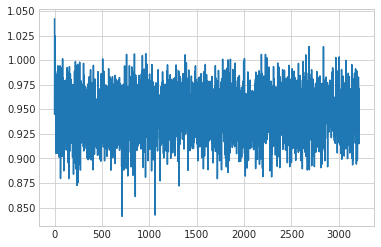

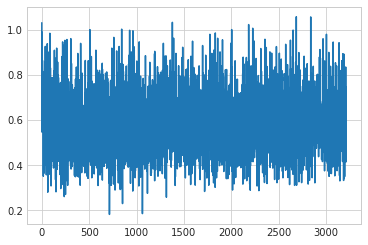

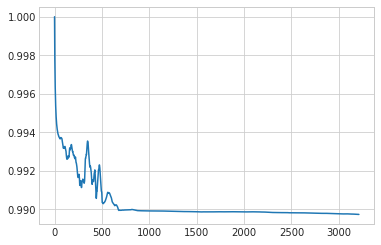

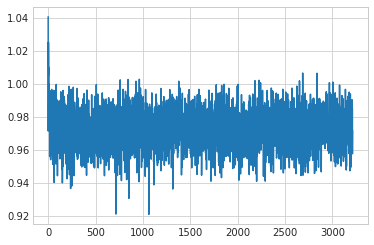

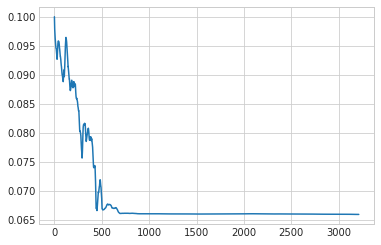

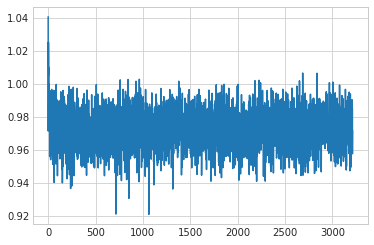

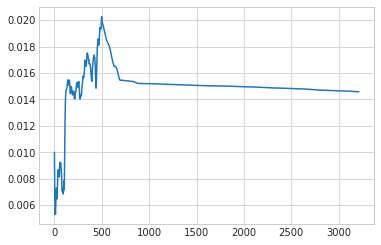

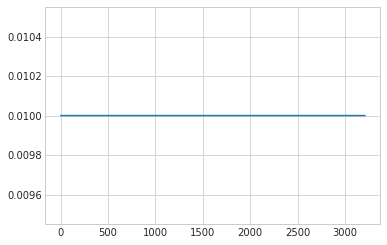

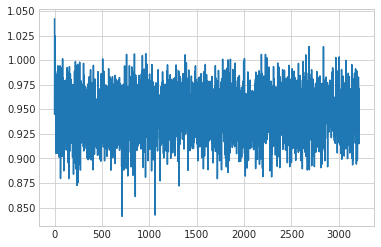

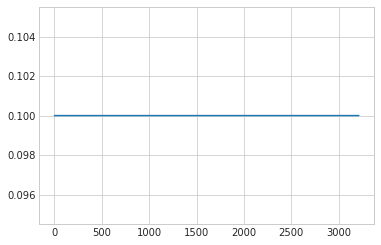

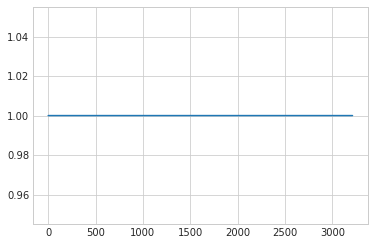

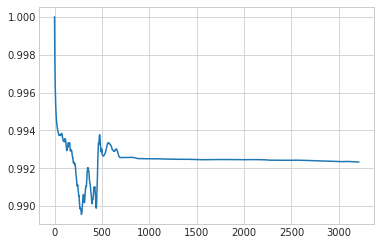

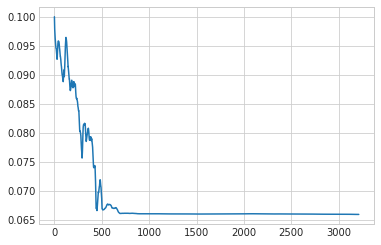

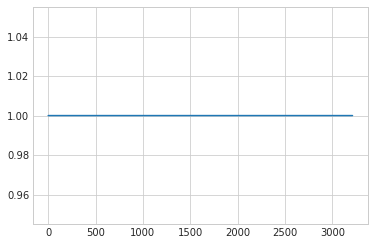

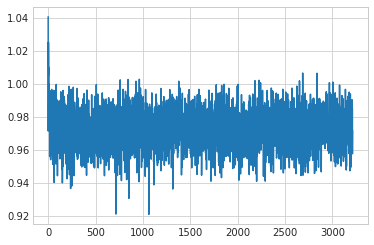

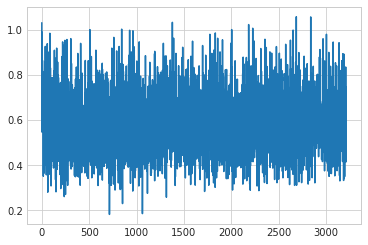

In [26]:
pattern = '../results/expts_2/bindingdb/results*_krr*/log*10*.txtkrr'
fnames = glob(pattern)
for fname in fnames:
    show_l2(fname)